##  SLIC Superpixels computation

RICCARDO CAPRILE 4370774

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, color, data
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

### PART 1 Skimage implementation  
Here we get a glimpse of SLIC, as we change the number of segments
You may check out the `skimage.segmentation.slic` documentation to understand the meaning of the other parameters (eg compactness)

In [2]:
# READ THE IMAGE
#image =data.astronaut()
image = io.imread('due.jpg')

<ipython-input-3-08bf065f7c3c>:6: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(image, n_segments = numSegments, sigma = 5,compactness=10)


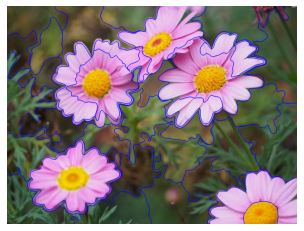

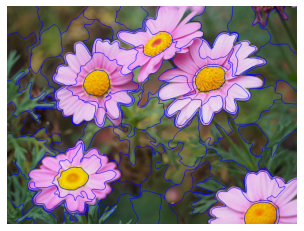

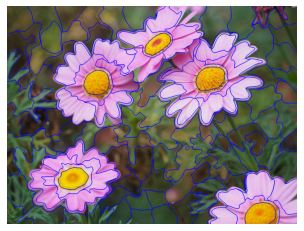

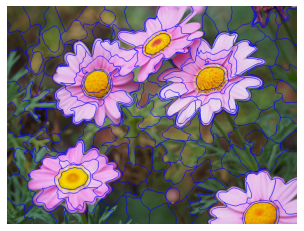

In [3]:
# CALLING THE SKIMAGE IMPLEMENTATION OF SLIC

for numSegments in (50,100,150,200): # select different values

    # Play Around with the Parameters
    segments = slic(image, n_segments = numSegments, sigma = 5,compactness=10)

    # Showing the Results
    fig = plt.figure("Superpixels -- %d segments" % numSegments)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments, color=(0,0,1),mode='thick'))
    plt.axis("off")
# show the plots
plt.show()

# DESCRIBE THE CHANGES WHEN USING DIFFENTS PARAMETER VALUES..

**Comment**

numSegments correspond to the number of labels in the segmented output image.

<ipython-input-13-80210b75375f>:5: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(image, n_segments = 100, sigma = sigmas,compactness=10)


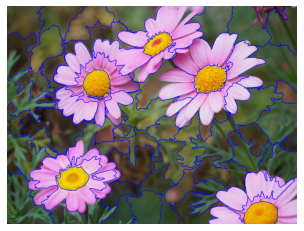

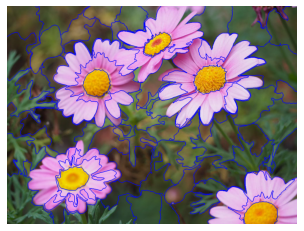

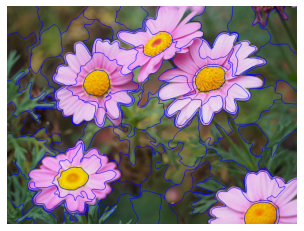

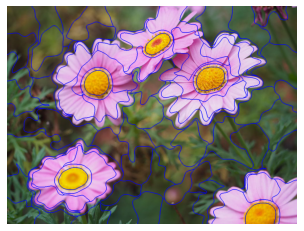

In [13]:
for sigmas in (0,1,5,10): # select different values

    # Play Around with the Parameters
    
    segments = slic(image, n_segments = 100, sigma = sigmas,compactness=10)

    # Showing the Results
    fig = plt.figure("Superpixels -- %d segments" % sigmas)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments, color=(0,0,1),mode='thick'))
    plt.axis("off")
# show the plots
plt.show()

**Comment**

Sigmas is responsible to the width of the Gaussian kernel for pre processing for each dimension of the image.

From the image is clear that with sigma equal to 0 the segmentation is affected by noise.

Increasing the sigma brings to a smoother segmentation

<ipython-input-16-34ea22981391>:5: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(image, n_segments = 100, sigma = sigmas,compactness=compactnesses)


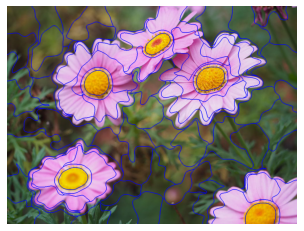

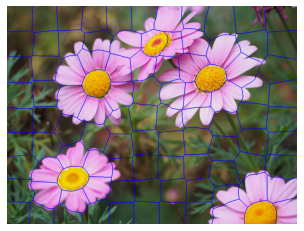

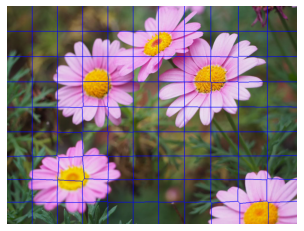

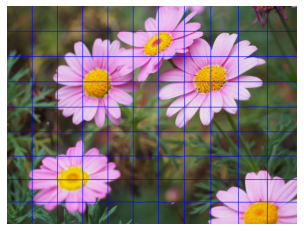

In [16]:
for compactnesses in (10,100,500,1000): # select different values

    # Play Around with the Parameters
    
    segments = slic(image, n_segments = 100, sigma = sigmas,compactness=compactnesses)

    # Showing the Results
    fig = plt.figure("Superpixels -- %d segments" % compactnesses)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments, color=(0,0,1),mode='thick'))
    plt.axis("off")
# show the plots
plt.show()

### PART 2 - Having a look  inside an implementation
Refer to  <a href="https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf"  > the original paper </a>  



In [17]:
class Cluster(object):
    cluster_index = 1

    def __init__(self, h, w, l=0, a=0, b=0):

        self.pixels = []
        self.no = self.cluster_index
        Cluster.cluster_index += 1
        self.h = h
        self.w= w
        self.l=l
        self.a=a
        self.b=b
        self.e = None

    def update(self, h, w, l, a, b):
        #compute the residual error
        self.e = np.sqrt(np.sum((np.array([h, w, l, a, b]) - np.array([self.h, self.w, self.l,self.a, self.b]))**2))
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b


In [25]:

class SLICProcessor(object):

    def __init__(self, img, num_segments=10, M=20, max_iter=10, error_threshold=10, verbose=True):
        self.K = num_segments
        self.M = M
        self.max_iter = max_iter

        self.data = color.rgb2lab(img) #the image converted to lab space
        self.image_height = self.data.shape[0] #image rows
        self.image_width = self.data.shape[1] #image cols
        self.N = self.image_height * self.image_width #pixel number

        self.S = int(math.sqrt(self.N / self.K)) #segment side
        self.error_threshold = error_threshold
        self.clusters = []
        self.label = {}
        self.dis = np.full((self.image_height, self.image_width), np.inf)
        # verbose regulates the printing of the error after every iteration
        self.verbose = verbose

    #create and return an object cluster
    def make_cluster(self, h, w):

        h = int(h)
        w = int(w)
        return Cluster(h, w,
                       self.data[h][w][0],
                       self.data[h][w][1],
                       self.data[h][w][2])


    #place initial clusters at the center of each initial segment
    def init_clusters(self):
        # start so that the first cluster is on the top left corner
        curr_h = int(self.S / 2)
        curr_w = int(self.S / 2)

        while curr_h < self.image_height:
            while curr_w < self.image_width:
                self.clusters.append(self.make_cluster(curr_h, curr_w))

                curr_w += self.S    # next cluster will be S elements away

            # once we iterated over the whole width of the image we have to:
            # go back to the left
            curr_w = int(self.S / 2)
            # go S element "down"
            curr_h += self.S

    #get gradient at point h,w
    def get_gradient(self, h, w):

        if w + 1 >= self.image_width:
            w = self.image_width - 2
        if h + 1 >= self.image_height:
            h = self.image_height - 2

        gradient_x = self.data[h+1][w]-self.data[h-1][w]#ADD estimate of partial derivative (x) in position (h,w)
        gradient_y = self.data[h][w+1]-self.data[h][w-1] #ADD estimate of partial derivative (y) in position (h,w)

        gradient =np.sqrt((gradient_x)**2+(gradient_y)**2) # ADD magnitude

        return gradient

    #adjust cluster center on low gradient points ( move to smaller gradient)
    def move_clusters(self):

        for cluster in self.clusters:
            cluster_gradient = self.get_gradient(cluster.h, cluster.w)
            #### locate minimum gradient in 3x3 area around the current cluster center
            min_i = 0
            min_j = 0
            for i in range(-1,2):
                for j in range(-1,2):
                    # if the 3x3 area of our cluster was to fall outside the image skip that position
                    if cluster.h + i < 0 or cluster.h + i >= self.image_height or cluster.w + j < 0 or cluster.w + j >= self.image_width:
                        continue
                    curr_gradient = self.get_gradient(cluster.h+i, cluster.w + j)
                    if curr_gradient < cluster_gradient:
                        # UPDATE appropriate variables

            # move cluster in point with smallest gradient
            # if it was already in the best spot we just move it by 0 pixels
                        new_h = cluster.h + min_i
                        new_w = cluster.w + min_j
            # doesn't matter that here we compute the residual error since in
            # process we perform at least one iteration
            # this allows us to keep the previous indexing
            cluster.update(new_h, new_w, self.data[new_h][new_w][0], self.data[new_h][new_w][1], self.data[new_h][new_w][2])


    #assign pixels to nearest cluster using the proposed distance in labxy space
    def assignment(self):

        for cluster in self.clusters:
            for h in range(cluster.h - 2 * self.S, cluster.h + 2 * self.S):
                if h < 0 or h >= self.image_height: continue
                for w in range(cluster.w - 2 * self.S, cluster.w + 2 * self.S):
                    if w < 0 or w >= self.image_width: continue
                    L, A, B = self.data[h][w]
                    #compute the distance in 5d space (see Eq (1) of the paper)
                    D_xy =np.sqrt((-)**2 + (-)**2 + (-)**2) # fill in
                    D_lab =np.sqrt((-)**2 + (-)**2)# fill in
                    D = np.sqrt(D_lab**2 + (D_xy / self.S)**2 * self.M**2)

                    if D < self.dis[h][w]:
                        if (h, w) not in self.label:
                            #if not yet assigned
                            self.label[(h,w)] = cluster
                            cluster.pixels.append((h,w))    # add current pixel to the list of pixels of its nearest cluster
                        else:
                            # re-assign
                            # this pixel already has a label, meaning that it can be found in
                            # the pixel list of its current cluster
                            # before updating remove it
                            self.label[(h,w)].pixels.remove((h,w))
                            self.label[(h,w)] = cluster
                            cluster.pixels.append((h,w))
                        #update new distance
                        self.dis[h][w] = D


    #update clusters centers using the average of member pixels
    def update_cluster(self):
        for cluster in self.clusters:
            sum_h = sum_w = number = 0
            for p in cluster.pixels:
                sum_h += p[0]
                sum_w += p[1]

            number = len(cluster.pixels)
            _h = int(sum_h / number)
            _w = int(sum_w / number)
            # place the cluster center at the centroid
            cluster.update(_h, _w, self.data[_h][_w][0], self.data[_h][_w][1], self.data[_h][_w][2])

    #get class membership per pixel
    def get_boundaries(self):

        image_arr = np.zeros((self.image_height,self.image_width),int)
        index = 0
        for cluster in self.clusters:
            for p in cluster.pixels:
                image_arr[p[0]][p[1]] = index
            index+=1
        return image_arr

   #algorithm steps
    def get_residual_error(self):
        tot_e = 0
        for cluster in self.clusters:
            tot_e += cluster.e
        return tot_e


    def process(self):
        self.init_clusters()
        self.move_clusters()
        for i in range(self.max_iter):
            self.assignment()
            self.update_cluster()

            error = self.get_residual_error()
            if self.verbose:
                print('Iteration %d, residual error E= %f' % (i,error))
            if error<1.0:
                break

        return self.get_boundaries()



### Let's test the implementation
you may want to measure the time and compare to python's version

In [26]:
# img2 = io.imread('due.jpg')
img2  = data.astronaut()

[row,col,c]=np.shape(img2)
# here I'm cropping the image to reduce the execution time
img2_crop = img2[:row//2,:col//2,:]

print(np.shape(img2_crop))

(256, 256, 3)


In [27]:
p = SLICProcessor(img2_crop, num_segments = 50, M=20, max_iter = 10)
boundaries = p.process()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

NameError: name 'boundaries' is not defined

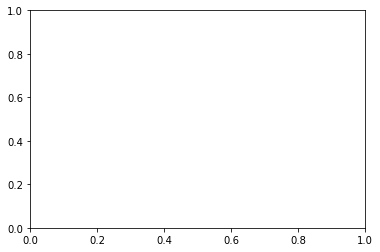

In [28]:
# visualize
fig = plt.figure("Superpixels -- %d segments" % 10)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(img2_crop, boundaries))
plt.axis("off")

plt.show()

In [ ]:
# COMPARE THE RESULTS BETWEEN THE SKIMAGE AND OURS



 ### What if we apply a low pass filter first?